In [70]:
import tensorflow as tf

## Create Images Dataset

In [83]:
# load and preprocess image with given path
def decode_image(path, resize=(60, 120)):
    # path example: xxx\abcd.jpg
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, resize)
    
    # to gray scale: so channels=1
    image = tf.image.rgb_to_grayscale(image)
    return image # shape=(h, w, 1)

# get labels
def get_labels(path, prefix):
    ''' this function is used within dataset.map(), 
        where eager execution is disables by default:
            check tf.executing_eagerly() returns False.
        So any Tensor.numpy() is not allowed in this function.
    '''
    labels = {}
    for i in range(4):
        c = tf.strings.substr(path, i-8, 1) # path example: b'xxx\abcd.jpg'
        label = tf.strings.unicode_decode(c, input_encoding='utf-8') - ord('a')
        labels[f'{prefix}_{i}'] = label
    return labels
          
# create image/labels dataset from path
def create_dataset_from_path(path_pattern, batch_size=32, image_size=(60, 120), label_prefix='labels'):            
    # create path dataset
    # by default, `tf.data.Dataset.list_files` gets filenames 
    # in a non-deterministic random shuffled order
    dataset = tf.data.Dataset.list_files(path_pattern).map(
        lambda image_path: (decode_image(image_path, image_size),
                            get_labels(image_path, label_prefix))).batch(batch_size)
    return dataset

In [86]:
# create (image, label) dataset from generator
train_ds = create_dataset_from_path('samples/train/*.jpg', batch_size=32, image_size=(60, 120))
test_ds = create_dataset_from_path('samples/test/*.jpg', batch_size=32, image_size=(60, 120))
train_ds.element_spec

(TensorSpec(shape=(None, 60, 120, 1), dtype=tf.float32, name=None),
 {'labels_0': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'labels_1': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'labels_2': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'labels_3': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)})

## Show Images in First Batch

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

# get images in first batch
batch_images, batch_labels = next(train_ds.take(1).as_numpy_iterator())

# check shape
print(batch_images.shape) # (batch_size, height, width, channels)

for k,v in batch_labels.items(): # batch_labels is a dict with batch size for each value
    print(k, ' -> ', v.shape) # batch_size

(32, 60, 120, 1)
labels_0  ->  (32, 1)
labels_1  ->  (32, 1)
labels_2  ->  (32, 1)
labels_3  ->  (32, 1)


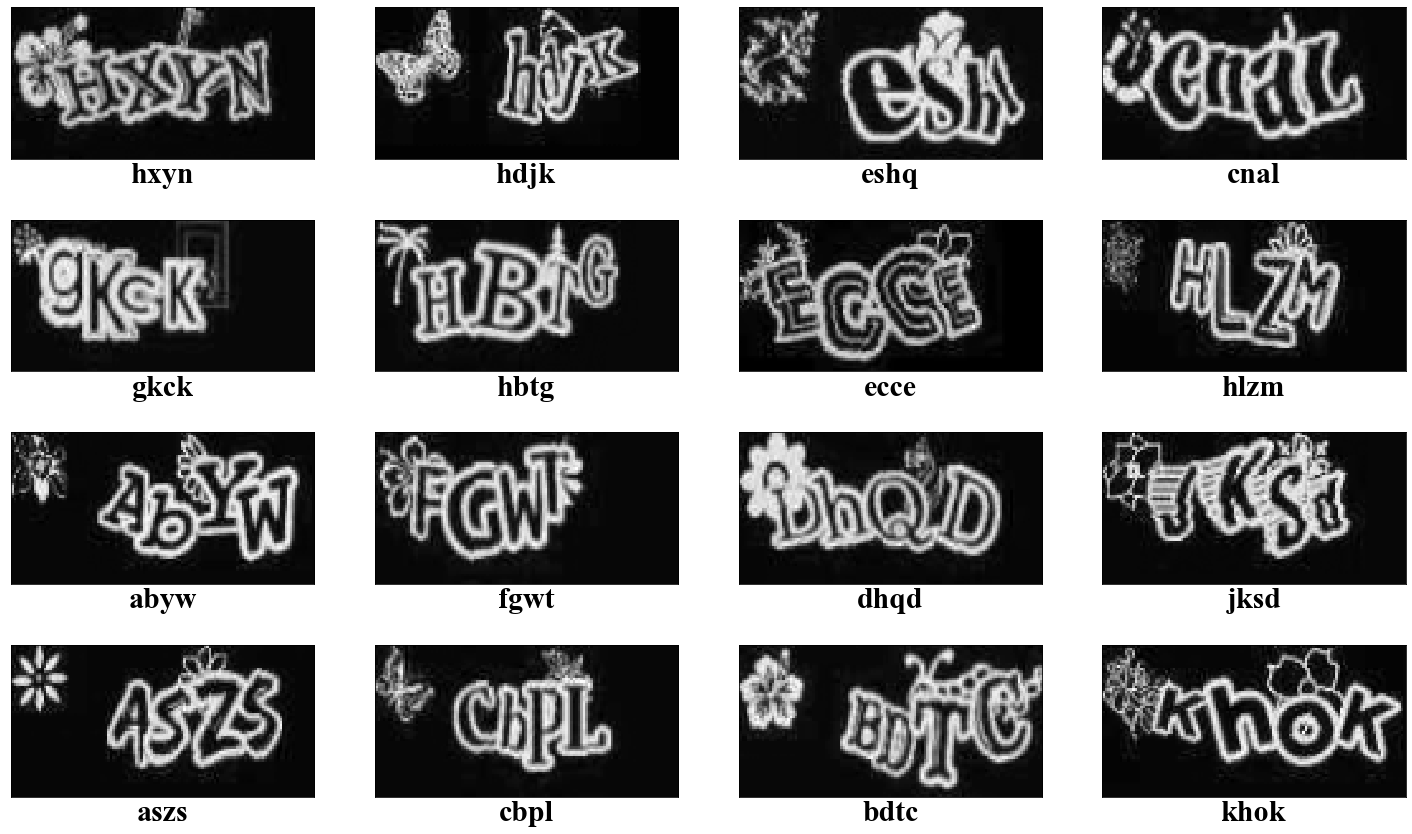

In [89]:
plt.figure(figsize=(25,15)) # width, height
for i,(image,*labels) in enumerate(zip(batch_images, *batch_labels.values()), start=1):
    if i > 16:  break
    plt.subplot(4, 4, i)
    
    # imshow get image shape: either (h, w, c=3) for RGB images
    # or (h, w) for gray image
    image = tf.reshape(image, shape=(60, 120))
    plt.imshow(image, cmap=plt.cm.binary)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(''.join([chr(ord('a') + c) for c in labels]), 
               fontdict={'family': 'Times New Roman', 'size' : 30})
plt.show()